In [1]:
from libraries import lib
import qutip as qt 
import torch
import numpy as np
import matplotlib.pyplot as plt
from kan import *

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
N, J, Gamma = 3, 1, 1
vars = (N, J, Gamma)
input = lib.generate_input_torch(N)
def amp_phase(nn_output):
    return nn_output[:, 0] * torch.exp(1.j * 2 * np.pi * nn_output[:, 1])
loss_fn = lib.TFIM_expectation_from_torch

In [4]:
model = KAN(width=[N, 2, 2], device=device) 

checkpoint directory created: ./model
saving model version 0.0


In [5]:
epochs = []
loss_data = []
optimizer = LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)
for epoch in range(10):
    print(epoch)
    def closure():
        optimizer.zero_grad()
        loss = loss_fn(model(input), vars, amp_phase)
        loss.backward()
        return loss + 0.001 * model.reg('edge_forward_spline_n', 1, 2, 0, 0)

    optimizer.step(closure)
    epochs.append(epoch)
    loss_data.append(loss_fn(model(input), vars, amp_phase).item())

# find groud state
gs = lib.model_to_ground_state(model, input, amp_phase)

0
1
2
3
4
5
6
7
8
9


In [6]:
model.reg('edge_forward_spline_n', 1, 2, 0, 0)

tensor(6.9570, grad_fn=<AddBackward0>)

In [7]:
calced = loss_data[-1]
actual = lib.TFIM_hamiltonian(N, J, Gamma).eigenstates()[0][0]
print('est', calced)
print('true', actual)
print('error', (calced - actual)**2)

est -3.999990463256836
true -4.0
error 9.094947017729282e-11


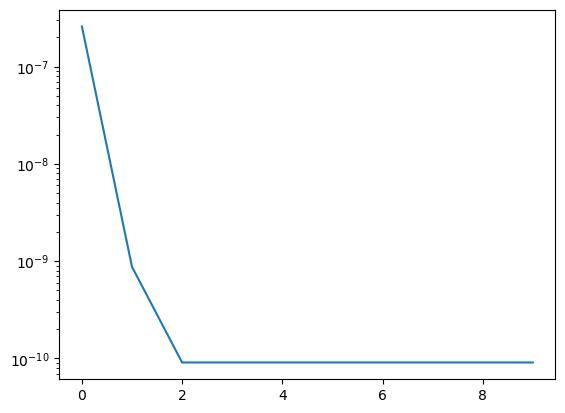

In [8]:
plt.plot(epochs, (np.array(loss_data) - np.array(len(loss_data) * [actual])) ** 2)
plt.yscale('log')
plt.show()

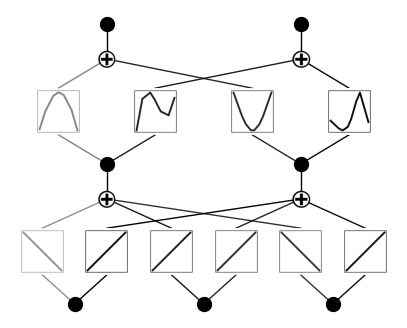

In [9]:
model.plot()

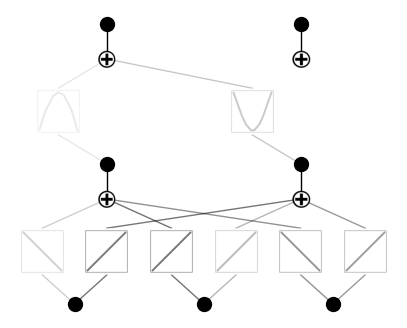

In [10]:
model.plot(metric='forward_u')

saving model version 0.1


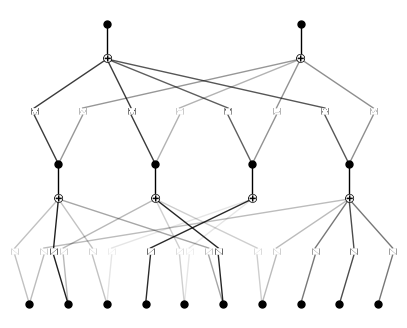

In [12]:
model = model.prune()
model.plot()

In [15]:
model.symbolic_formula()

([0, 0], [x_1, x_2, x_3])